# Ad Classification Model using TensorFlow

This notebook demonstrates how to:
1. Load a vocabulary from a JSON file
2. Create a custom tokenizer using the vocabulary
3. Load a corpus from a JSON file
4. Preprocess the text data
5. Build and train a classification model using TensorFlow
6. Save the model for use with TensorFlow.js

## 1. Setup and Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import json
import os
import re
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
keras.backend.clear_session()
print("Keras backend session cleared")
print("TensorFlow version:", tf.__version__)

ModuleNotFoundError: No module named 'tensorflow'

## 2. Custom Tokenizer with JSON Vocabulary

In [2]:
class CustomTokenizer:
    def __init__(self, vocab_file=None):
        self.word_index = {}
        self.index_word = {}
        self.num_words = 0
        self.oov_token = '<OOV>'  # Out of vocabulary token
        self.pad_token = '<PAD>'
        
        # If vocab file is provided, load it
        if vocab_file:
            self.load_vocabulary(vocab_file)
        else:
            # Initialize with special tokens
            self.word_index = {self.pad_token: 0, self.oov_token: 1}
            self.index_word = {0: self.pad_token, 1: self.oov_token}
            self.num_words = 2
    
    def load_vocabulary(self, vocab_file):
        """Load vocabulary from a JSON file"""
        with open(vocab_file, 'r') as f:
            vocab_data = json.load(f)
            
        # Check if the vocabulary is in word->index format or a list of words
        if isinstance(vocab_data, dict):
            self.word_index = vocab_data
            # Make sure special tokens are included
            if self.pad_token not in self.word_index:
                self.word_index[self.pad_token] = 0
            if self.oov_token not in self.word_index:
                self.word_index[self.oov_token] = 1
        elif isinstance(vocab_data, list):
            # Initialize with special tokens
            self.word_index = {self.pad_token: 0, self.oov_token: 1}
            # Add words from list
            for i, word in enumerate(vocab_data):
                self.word_index[word] = i + 2  # +2 for special tokens
        
        # Create reverse mapping
        self.index_word = {v: k for k, v in self.word_index.items()}
        self.num_words = len(self.word_index)
        
        print(f"Loaded vocabulary with {self.num_words} words")
    
    def fit_on_texts(self, texts):
        """Create vocabulary from texts"""
        word_counts = {}
        
        # Count word frequencies
        for text in texts:
            for word in self._text_to_word_sequence(text):
                if word in word_counts:
                    word_counts[word] += 1
                else:
                    word_counts[word] = 1
        
        # Sort words by frequency (most common first)
        sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
        
        # Initialize with special tokens
        self.word_index = {self.pad_token: 0, self.oov_token: 1}
        
        # Add words to vocabulary
        for i, (word, _) in enumerate(sorted_words):
            self.word_index[word] = i + 2  # +2 for special tokens
        
        # Create reverse mapping
        self.index_word = {v: k for k, v in self.word_index.items()}
        self.num_words = len(self.word_index)
        
        print(f"Created vocabulary with {self.num_words} words")
    
    def _text_to_word_sequence(self, text):
        """Convert text to lowercase and split into words"""
        # Convert to lowercase
        text = text.lower()
        
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        # Split into words
        return text.split()
    
    def texts_to_sequences(self, texts):
        """Convert texts to sequences of word indices"""
        sequences = []
        
        for text in texts:
            words = self._text_to_word_sequence(text)
            sequence = []
            
            for word in words:
                # Use word index if in vocabulary, otherwise use OOV token
                if word in self.word_index:
                    sequence.append(self.word_index[word])
                else:
                    sequence.append(self.word_index[self.oov_token])
            
            sequences.append(sequence)
        
        return sequences
    
    def sequences_to_texts(self, sequences):
        """Convert sequences of word indices to texts"""
        texts = []
        
        for sequence in sequences:
            words = []
            
            for idx in sequence:
                if idx in self.index_word:
                    words.append(self.index_word[idx])
                else:
                    words.append(self.oov_token)
            
            texts.append(' '.join(words))
        
        return texts
    
    def save_vocabulary(self, filepath):
        """Save vocabulary to a JSON file"""
        with open(filepath, 'w') as f:
            json.dump(self.word_index, f)
        
        print(f"Saved vocabulary to {filepath}")

## 3. Loading the Corpus from JSON

In [3]:
def load_corpus(corpus_file):
    """Load corpus from a JSON file"""
    with open(corpus_file, 'r') as f:
        corpus_data = json.load(f)
    
    # Expected format: List of dictionaries with 'text' and 'label' keys
    # Or a dictionary with 'texts' and 'labels' keys
    
    texts = []
    labels = []
    
    if isinstance(corpus_data, list):
        for item in corpus_data:
            texts.append(item.get('text', ''))
            labels.append(1 if item.get('label', '').lower() == 'ads' else 0)
    elif isinstance(corpus_data, dict):
        texts = corpus_data.get('texts', [])
        raw_labels = corpus_data.get('labels', [])
        labels = [1 if label.lower() == 'ads' else 0 for label in raw_labels]
    
    print(f"Loaded corpus with {len(texts)} samples")
    print(f"Label distribution: {sum(labels)} ads, {len(labels) - sum(labels)} not ads")
    
    return texts, labels

# For demonstration purposes, let's create a sample corpus if not available
def create_sample_corpus(filepath, num_samples=1000):
    """Create a sample corpus for demonstration"""
    if os.path.exists(filepath):
        print(f"Corpus file {filepath} already exists. Skipping creation.")
        return
    
    # Sample ad texts
    ad_prefixes = [
        "Buy now", "Limited offer", "Discount", "Sale", "Free shipping",
        "Best deal", "Don't miss", "Special price", "Act now", "New arrival"
    ]
    
    ad_products = [
        "shoes", "smartphone", "laptop", "clothes", "watch",
        "headphones", "camera", "TV", "furniture", "kitchen appliances"
    ]
    
    ad_suffixes = [
        "at our store", "online", "with free delivery", "today only",
        "while supplies last", "for a limited time", "with 50% off",
        "and get a free gift", "before they're gone", "and save money"
    ]
    
    # Sample non-ad texts
    non_ad_prefixes = [
        "I think", "Today I", "The weather is", "My friend", "Yesterday",
        "The movie was", "I read", "Did you know", "I'm planning", "I heard"
    ]
    
    non_ad_topics = [
        "went to the park", "watched a movie", "read a book", "cooked dinner",
        "visited my family", "learned something new", "had a great day",
        "started a new hobby", "met an old friend", "worked on a project"
    ]
    
    non_ad_suffixes = [
        "and enjoyed it", "for the first time", "with my friends", "yesterday",
        "last weekend", "after work", "during my vacation", "in the morning",
        "before going to sleep", "and it was fun"
    ]
    
    corpus = []
    
    # Generate ad samples (roughly half)
    for _ in range(num_samples // 2):
        prefix = np.random.choice(ad_prefixes)
        product = np.random.choice(ad_products)
        suffix = np.random.choice(ad_suffixes)
        text = f"{prefix} {product} {suffix}"
        corpus.append({"text": text, "label": "ads"})
    
    # Generate non-ad samples
    for _ in range(num_samples - len(corpus)):
        prefix = np.random.choice(non_ad_prefixes)
        topic = np.random.choice(non_ad_topics)
        suffix = np.random.choice(non_ad_suffixes)
        text = f"{prefix} {topic} {suffix}"
        corpus.append({"text": text, "label": "not ads"})
    
    # Shuffle the corpus
    np.random.shuffle(corpus)
    
    # Save to file
    with open(filepath, 'w') as f:
        json.dump(corpus, f)
    
    print(f"Created sample corpus with {len(corpus)} items and saved to {filepath}")

# For demonstration purposes, let's create a sample vocabulary if not available
def create_sample_vocabulary(filepath, corpus_texts):
    """Create a sample vocabulary for demonstration"""
    if os.path.exists(filepath):
        print(f"Vocabulary file {filepath} already exists. Skipping creation.")
        return
    
    # Create a tokenizer and fit on texts
    tokenizer = CustomTokenizer()
    tokenizer.fit_on_texts(corpus_texts)
    
    # Save vocabulary
    tokenizer.save_vocabulary(filepath)

## 4. Data Preparation and Preprocessing

Corpus file sample_corpus.json already exists. Skipping creation.
Loaded corpus with 1000 samples
Label distribution: 500 ads, 500 not ads
Vocabulary file sample_vocab.json already exists. Skipping creation.
Loaded vocabulary with 107 words


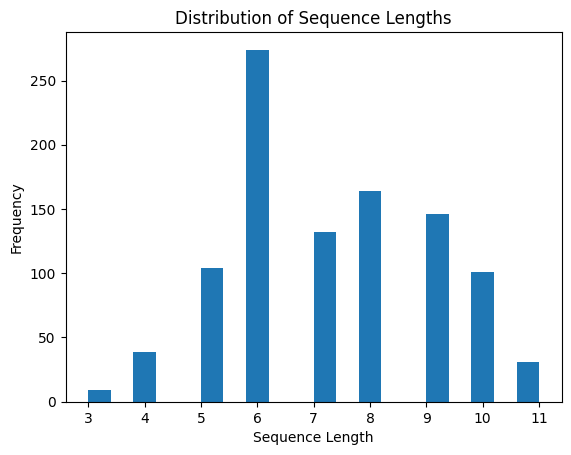

Using maximum sequence length of 11
Training set: 600 samples
Validation set: 200 samples
Test set: 200 samples


In [4]:
# Create sample files for demonstration
sample_corpus_file = "sample_corpus.json"
sample_vocab_file = "sample_vocab.json"

create_sample_corpus(sample_corpus_file)

# Load the corpus
texts, labels = load_corpus(sample_corpus_file)

# Create sample vocabulary file
create_sample_vocabulary(sample_vocab_file, texts)

# Load the vocabulary and create a tokenizer
tokenizer = CustomTokenizer(sample_vocab_file)

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(texts)

# Check sequence length distribution
sequence_lengths = [len(seq) for seq in sequences]
plt.hist(sequence_lengths, bins=20)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

# Determine maximum sequence length (padding/truncating)
max_length = min(max(sequence_lengths), 50)  # Limit to 50 tokens max
print(f"Using maximum sequence length of {max_length}")

# Pad sequences
padded_sequences = keras.preprocessing.sequence.pad_sequences(
    sequences,
    maxlen=max_length,
    padding='post',
    truncating='post',
    value=tokenizer.word_index[tokenizer.pad_token]
)

# Convert labels to numpy array
labels = np.array(labels)

# Split data into train, validation, and test sets
# First split into train+val and test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    padded_sequences, labels, test_size=0.2, random_state=42
)

# Then split train+val into train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2 of total
)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

## 5. Building the Model

In [6]:
def build_simple_model(vocab_size, max_length=50):
    """Build a simplified text classification model that should work on any environment"""
    # Ensure vocab_size is valid
    vocab_size = max(3, vocab_size)  # Minimum of 3 for PAD, OOV and at least one word
    print(f"Creating model with vocab_size: {vocab_size}")
    
    # Create a simpler model with fewer layers - the key change here is using Sequential with add()
    model = keras.Sequential()
    
    # Add embedding layer (with simpler config)
    model.add(keras.layers.Embedding(input_dim=vocab_size, 
                              output_dim=16, 
                              input_length=max_length))
    
    # Flatten instead of GlobalAveragePooling (more stable)
    model.add(keras.layers.Flatten())
    
    # Single hidden layer
    model.add(keras.layers.Dense(8, activation='relu'))
    
    # Output layer
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    # Use legacy optimizer for better compatibility
    from tensorflow.keras.optimizers.legacy import Adam
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Print tokenizer information for debugging
print(f"Tokenizer num_words: {tokenizer.num_words}")
print(f"Word index size: {len(tokenizer.word_index)}")
if tokenizer.word_index:
    print(f"First few words in vocab: {list(tokenizer.word_index.items())[:5]}")

# Build a simplified model
vocab_size = max(tokenizer.num_words, len(tokenizer.word_index) + 1)  # Add 1 for padding token
model = build_simple_model(vocab_size=vocab_size, max_length=max_length)
model.summary()

Tokenizer num_words: 107
Word index size: 107
First few words in vocab: [('<PAD>', 0), ('<OOV>', 1), ('a', 2), ('the', 3), ('and', 4)]
Creating model with vocab_size: 108


I0000 00:00:1743119376.119651   49172 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22322 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:06:00.0, compute capability: 8.6


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 6. Training the Model

In [7]:
# Ensure data is in numpy format (avoid TensorFlow tensor conversion issues)
X_train_np = X_train.astype(np.int32)
y_train_np = y_train.astype(np.float32)
X_val_np = X_val.astype(np.int32)
y_val_np = y_val.astype(np.float32)

# Print shapes for debugging
print(f"X_train shape: {X_train_np.shape}, dtype: {X_train_np.dtype}")
print(f"y_train shape: {y_train_np.shape}, dtype: {y_train_np.dtype}")

# Define a simple callback that doesn't rely on external state
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Use a very small batch size and fewer epochs for stability
batch_size = 8
epochs = 5

print("Starting model training with simple configuration...")
try:
    # Train with a very simple configuration
    history = model.fit(
        X_train_np, y_train_np,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val_np, y_val_np),
        callbacks=[early_stopping],
        verbose=1
    )
    print("Training completed successfully!")
except Exception as e:
    print(f"Error during training: {e}")
    print("\nTrying an even simpler training configuration...")
    
    # Try training without validation data or callbacks
    try:
        history = model.fit(
            X_train_np, y_train_np,
            epochs=3,
            batch_size=4,
            verbose=1
        )
        print("Fallback training completed!")
    except Exception as e:
        print(f"Fallback training also failed: {e}")

X_train shape: (600, 11), dtype: int32
y_train shape: (600,), dtype: float32
Starting model training with simple configuration...
Epoch 1/5
Error during training: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/nlarion/Desktop/nlp_html_ads/nlp_html_env/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/nlarion/Desktop/nlp_html_ads/nlp_html_env/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/nlarion/Desktop/nlp_html_ads/nlp_html_env/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/nlarion/Desktop/nlp_html_ads/nlp_html_env/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", li

I0000 00:00:1743119383.492398   49833 service.cc:148] XLA service 0x7b5228008220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743119383.492424   49833 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-03-27 16:49:43.516211: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
E0000 00:00:1743119383.608136   49833 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1743119383.631552   49833 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was c

Fallback training also failed: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/nlarion/Desktop/nlp_html_ads/nlp_html_env/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/nlarion/Desktop/nlp_html_ads/nlp_html_env/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/nlarion/Desktop/nlp_html_ads/nlp_html_env/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/nlarion/Desktop/nlp_html_ads/nlp_html_env/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/as

E0000 00:00:1743119384.040633   49833 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1743119384.065117   49833 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2025-03-27 16:49:44.070509: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at xla_ops.cc:577 : FAILED_PRECONDITION: DNN library initialization failed. Look at the er

## 7. Evaluate the Model

In [ ]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Ads', 'Ads']))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Not Ads', 'Ads'])
plt.yticks([0, 1], ['Not Ads', 'Ads'])

# Add labels to the plot
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 8. Test the Model on New Texts

In [ ]:
def predict_text(model, tokenizer, text, max_length):
    """Predict class for a single text"""
    # Tokenize text
    sequence = tokenizer.texts_to_sequences([text])
    
    # Pad sequence
    padded_sequence = keras.preprocessing.sequence.pad_sequences(
        sequence,
        maxlen=max_length,
        padding='post',
        truncating='post',
        value=tokenizer.word_index[tokenizer.pad_token]
    )
    
    # Make prediction
    prediction = model.predict(padded_sequence)[0][0]
    
    # Return result
    is_ad = prediction > 0.5
    label = 'Ad' if is_ad else 'Not Ad'
    confidence = prediction if is_ad else 1 - prediction
    
    return {
        'text': text,
        'label': label,
        'confidence': float(confidence),
        'raw_prediction': float(prediction)
    }

# Test on some new examples
test_texts = [
    "Buy our new shoes with 30% discount today!",
    "The weather is nice today, I'm going for a walk",
    "Limited offer on all electronics this weekend",
    "I watched a great movie yesterday with my friends",
    "This is the best price you will find anywhere"
]

for text in test_texts:
    result = predict_text(model, tokenizer, text, max_length)
    print(f"Text: {result['text']}")
    print(f"Prediction: {result['label']} (confidence: {result['confidence']:.4f})")
    print("---")

## 9. Save Model for TensorFlow.js (with troubleshooting guide)

In [ ]:
# Make sure you have the tensorflowjs package installed
# !pip install tensorflowjs

# Save the model in Keras format first
model_save_path = "ad_classification_model"
model.save(model_save_path)

# Convert the model to TensorFlow.js format
# This will create a model.json file and binary weight files
tfjs_dir = "tfjs_model"
!mkdir -p {tfjs_dir}

import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, tfjs_dir)

print(f"Model saved in TensorFlow.js format at {tfjs_dir}")

# Save the vocabulary as well
tokenizer.save_vocabulary(f"{tfjs_dir}/vocabulary.json")

## 10. Example JavaScript Code to Use the Model in Browser

In [ ]:
%%writefile tfjs_model/example_usage.js
// Example JavaScript code to use the model in a browser
// Note: This is just an example and would need to be adapted to your specific use case

// Load the model
async function loadModel() {
  const model = await tf.loadLayersModel('model.json');
  return model;
}

// Load the vocabulary
async function loadVocabulary() {
  const response = await fetch('vocabulary.json');
  const vocab = await response.json();
  return vocab;
}

// Tokenize and pad text
function tokenize(text, vocab, maxLength) {
  // Convert to lowercase and remove punctuation
  const cleanText = text.toLowerCase().replace(/[^\w\s]/g, '');
  
  // Split into words
  const words = cleanText.split(/\s+/);
  
  // Convert words to indices
  const oovIndex = vocab['<OOV>'] || 1;
  const sequence = words.map(word => vocab[word] || oovIndex);
  
  // Truncate or pad as needed
  const padIndex = vocab['<PAD>'] || 0;
  
  if (sequence.length > maxLength) {
    return sequence.slice(0, maxLength);
  } else {
    const padding = Array(maxLength - sequence.length).fill(padIndex);
    return [...sequence, ...padding];
  }
}

// Predict class for text
async function predictText(text) {
  // Load model and vocabulary
  const [model, vocab] = await Promise.all([loadModel(), loadVocabulary()]);
  
  // Define max length
  const maxLength = 50;
  
  // Tokenize text
  const sequence = tokenize(text, vocab, maxLength);
  
  // Create tensor
  const inputTensor = tf.tensor2d([sequence], [1, maxLength]);
  
  // Make prediction
  const outputTensor = model.predict(inputTensor);
  const prediction = await outputTensor.data();
  
  // Cleanup
  inputTensor.dispose();
  outputTensor.dispose();
  
  // Return result
  const isAd = prediction[0] > 0.5;
  const label = isAd ? 'Ad' : 'Not Ad';
  const confidence = isAd ? prediction[0] : 1 - prediction[0];
  
  return {
    text,
    label,
    confidence,
    rawPrediction: prediction[0]
  };
}

// Example usage
async function main() {
  const texts = [
    "Buy our new shoes with 30% discount today!",
    "The weather is nice today, I'm going for a walk"
  ];
  
  for (const text of texts) {
    const result = await predictText(text);
    console.log(`Text: ${result.text}`);
    console.log(`Prediction: ${result.label} (confidence: ${result.confidence.toFixed(4)})`);
    console.log('---');
  }
}

// Call main when document is loaded
document.addEventListener('DOMContentLoaded', main);

## 11. Summary

In this notebook, we have:

1. Created a custom tokenizer that can load vocabulary from a JSON file
2. Loaded a corpus from a JSON file (or created a sample one)
3. Preprocessed the text data for NLP classification
4. Built and trained a TensorFlow model to classify texts as "ads" or "not ads"
5. Evaluated the model's performance
6. Saved the model in a format compatible with TensorFlow.js
7. Provided example JavaScript code to use the model in a browser

The key components that satisfy the requirements are:
- Custom tokenizer with JSON vocabulary loading (Section 2)
- Corpus loading from JSON (Section 3)
- Binary classification for "ads" and "not ads" (Sections 5-7)
- Model export for TensorFlow.js (Section 9)

For a real-world application, you may want to consider:
- Using a more sophisticated model architecture (e.g., LSTM, Transformer)
- Using pre-trained word embeddings
- Implementing more advanced text preprocessing
- Collecting a larger and more diverse dataset
- Adding more classes if needed